In [1]:
from fastai import *
from fastai.vision.all import *
from models import SimpleAutoencoder

import sys
sys.path.append('..')
from src.band_plotters import *

from resnet_autoencoder import model

## Load

In [2]:
class Binarize(Transform):
    def __init__(self, threshold=0.8):self.threshold=threshold
    def encodes(self, o): 
        # print(o)
        mask = (o > (255 * self.threshold))
        return mask * 255

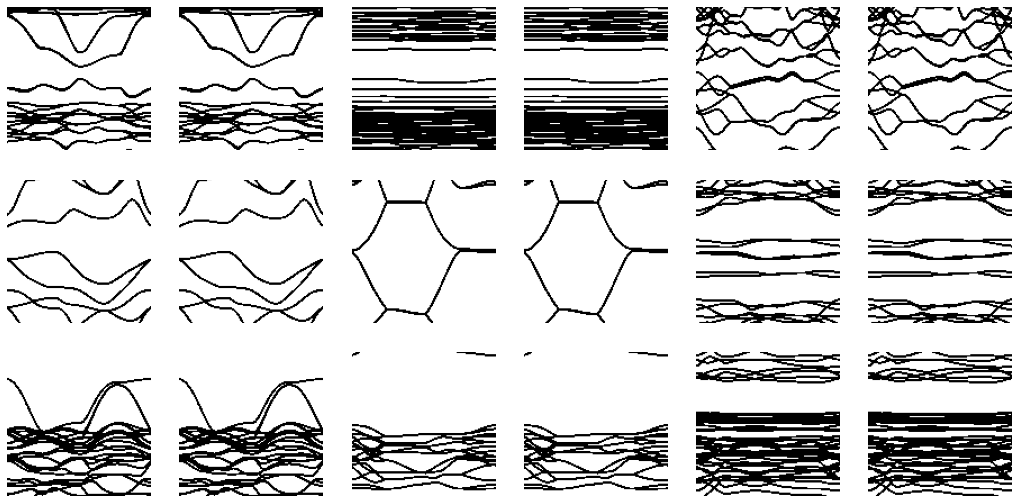

In [3]:
dls = DataBlock(
    blocks=(ImageBlock, ImageBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    item_tfms=[Resize((128))],
    batch_tfms=[Binarize()]
        ).dataloaders(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3", bs=32)

dls.show_batch()

In [15]:
xb, yb = dls.one_batch()
xb.shape

torch.Size([32, 3, 128, 128])

## Train

### Create Learner

In [16]:
def log_cosh_loss(pred, targ, a):
    loss = (1/a) * torch.log(torch.cosh(a*(pred-targ)))
    
    return loss.mean()

# loss = partial(log_cosh_loss, a=0.55)

In [4]:
# for arch in ["resnet18"]:
loss = F.mse_loss
# loss = partial(log_cosh_loss, a=1)
# loss = nn.BCEWithLogitsLoss()
sigmoid = True
if isinstance(loss, nn.BCEWithLogitsLoss):
    sigmoid = False
Z_CHANNELS = 32

# ae = model.BuildAutoEncoder("resnet18", sigmoid=sigmoid, z_channels=Z_CHANNELS)
ae = model.ResNetAutoEncoderCompressed([2, 2, 2, 2], False, 64)
learn = Learner(dls, ae, loss, cbs=[ShowGraphCallback()])
learn.fit_one_cycle(10)


xb, yb = dls.valid.one_batch()
# print(arch)
print(learn.model.encoder(xb.cuda()).shape)

epoch,train_loss,valid_loss,time


NameError: name 'F' is not defined

## Save and Load Learner

In [20]:
learn.export(f"trained_models/resnet18_size128_lossMSE_channels{Z_CHANNELS}.pkl")
# learn = load_learner("trained_models/resnet18_size128_lossMSE_channels6.pkl")
# out = learn.predict(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/2dm-1.png")
# show_image(out[1])

## View Predictions

In [ ]:
from ipywidgets import interact

def show(i):
    xb, yb = dls.valid.one_batch()
    learn.cuda()
    preds = learn.model(xb)
    # if False:
    #     preds = F.sigmoid(preds)
    show_image(xb[i])
    show_image(preds[i])
    
    # print(learn.model.encoder(xb.cuda()).shape)

    

interact(show, i=(0, len(xb)-1))

In [32]:
learn.get_preds??

Signature:
learn.get_preds(
    ds_idx=1,
    dl=None,
    with_input=False,
    with_decoded=False,
    with_loss=False,
    act=None,
    inner=False,
    reorder=True,
    cbs=None,
    *,
    save_preds: 'Path' = None,
    save_targs: 'Path' = None,
    with_preds: 'bool' = True,
    with_targs: 'bool' = True,
    concat_dim: 'int' = 0,
    pickle_protocol: 'int' = 2,
)
Docstring: Get the predictions and targets on the `ds_idx`-th dbunchset or `dl`, optionally `with_input` and `with_loss`
Source:   
    @delegates(GatherPredsCallback.__init__)
    def get_preds(self, ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, act=None,
                  inner=False, reorder=True, cbs=None, **kwargs):
        if dl is None: dl = self.dls[ds_idx].new(shuffle=False, drop_last=False)
        else:
            try: len(dl)
            except TypeError as e:
                raise TypeError(f"`dl` is {type(dl)} and doesn't have len(dl)")
        if isinstance(dl, DataLoader)

In [45]:
dl = learn.dls.test_dl([DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/2dm-1.png"])
dl.